# Abgabe Leistungsnachweis

Für den Leistungsnachweis in Coding in GIS sollt ihr einen Report abgeben. Hier sind die Rahmenbedigungen:

- **Ziel**: Beantwortung der Frage "*Welcher Anteil der Zeckenstiche befinden sich im Wald*" unter besonderer Berücksichtigung der Datenungenauigkeit.
- **Inhalt**: Vorgehen gemäss {numref}`fig-sim-workflow`, der Inhalt ist gegeben durch {ref}`chap-waldanteil` sowie der [Zusatzaufträge](chap-abgabe-zusatz)
- **Struktur**: Führt die Datenanlyse durch, indem ihr den Python Code mit Markdown Text unterstützt. Beschreibt und begründet eure Analyseschritte und wie die Resultate zu interpetieren sind. Der Fokus soll auf der technischen Umsetzung liegen, nicht auf der Interpretation der Resultate.
- **Abgabe**: 
  - Ein Jupyter-Notebook-File (\*.ipynb) **und**
  - Ein html-Export des Jupyter-Notebook Files:
      - **Wichtig:** Zuerst alle Zellen ausführen (*Run > Run all cells*)
      - Export via *File > Export Notebook as > Export Notebook to html*

(chap-abgabe-zusatz)=
## Zusatzaufträge

### Auftrag 1

Um den ganzen *Workflow* zu entwickeln haben wir es bisher bewusst einfach gehalten. Wir verwendeten nur 10 Zeckenstichen und führten 5 Iterationen ("*Runs*") durch.
 - Führe die ganze Analyse mit dem ganzen Datensatz `zeckenstiche_full.csv` (1'076 Meldungen, siehe {numref}`table-datensaetze`) durch 
 - Erhöhe die Anzahl Iterationen von 5 auf 50
 

### Auftrag 2

Wir simulieren die Zeckenstiche, indem wir die Original-Meldungen mit der Funktion `offset_coordinate` um einen Zufallswert verschieben (siehe {ref}`ex-offset-function`). Dieser Zufallswert stammt aus einer Verteilung mit Mittelwert `0` und Standartabweichung `100`. Variere in deiner Analyse die Standartabweichung und nutze nebst `100` zwei andere Werte, Beispielsweise `10` und `1'000`. Schau dir {ref}`ex-param` nochmals an wenn du nicht mehr weisst, wie das geht.


```{tip}
:class: dropdown

**Für Profis**: Statt das ihr den *For Loop* 3x kopiert könnt ihr auch einen verschachtelten *For Loop* konstuieren, wo der äussere *Loop* über die Radien iteriert, der innere besteht aus dem bisherigen *For Loop*. Wichtig dabei ist, dass die Liste `monte_carlo` vor dem äusseren Loop kontruiert wird und im DataFrame jeweils gespeichert wird, was für ein Radius verwendet wurde. Diese Spalte kann danach in `groupby` wie auch bei `.boxplot()` verwendet werden (siehe unten).
```

```python
# Musterlösung

# Benötigten Module laden #####################
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
###############################################
# Notwendige Functions definieren #############
def offset_coordinate(old, distance = 100):
    import random
    new = old + random.normalvariate(0,distance)
    return(new)
###############################################

# Daten Importieren ###########################
zeckenstiche_full = pd.read_csv("data/zeckenstiche_full.csv")
wald = gpd.read_file("data/wald.gpkg")
###############################################

radii = [10,100,1000]
monte_carlo2 = []

for radius in radii:
    for i in range(10):
        zeckenstiche_full["x_sim"] = zeckenstiche_full["x"].apply(offset_coordinate)
        zeckenstiche_full["y_sim"] = zeckenstiche_full["y"].apply(offset_coordinate)
        zeckenstiche_full["Run"] = i
        zeckenstiche_full["Radius"] = radius
        monte_carlo2.append(zeckenstiche_full.copy())
    
monte_carlo_df2 = pd.concat(monte_carlo2)

monte_carlo_gpd2 = gpd.GeoDataFrame(monte_carlo_df2,
                                    geometry=gpd.points_from_xy(monte_carlo_df2['x_sim'], monte_carlo_df2['y_sim']),
                                    crs = 2056) 

monte_carlo_join2 = gpd.sjoin(monte_carlo_gpd2, wald)

```

```python
monte_carlo_join2.to_file("data/monte_carlo_join2.gpkg", driver = "GPKG")
```

In [4]:
monte_carlo_join2 = gpd.read_file("data/monte_carlo_join2.gpkg")

<AxesSubplot:title={'center':'ja_anteil'}, xlabel='Radius'>

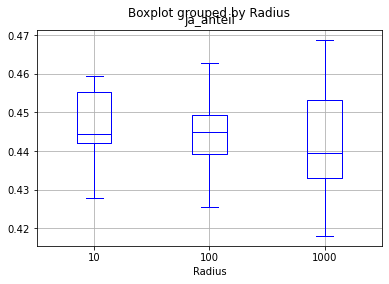

In [5]:
results = monte_carlo_join2.groupby(["Radius","Run","Wald_text"]).size().unstack(fill_value = 0).assign(ja_anteil = lambda x: x.ja/(x.ja+x.nein))
                                                                             
results.boxplot(column = "ja_anteil",by = "Radius", color = "blue")